# General Machine Learning Procedures

## Part1 Data Pre-Processing

### Read in data

In [4]:
import numpy as np
import pandas as pd
import csv
import re
from IPython.display import display

in_file = 'G:/onedrive/document/python_projects/uber/sTEF.csv'
full_data = pd.read_csv(in_file)

print "finished read in data"

#display(full_data.head())

finished read in data


### pre-processing datetime/categorical/null data

#### processing categorical variable

In [7]:
#processing categorical variable
from sklearn import preprocessing
for column in full_data:
    if column in ('city_name','signup_os', 'signup_channel',
                  'vehicle_make','vehicle_model'):
        new_col = pd.get_dummies(full_data[column], 
                                 prefix=column, dummy_na=True)
        full_data = pd.concat([full_data, new_col], axis=1)

print "preprocessing categorical data"


preprocessing categorical data


#### converting date object to date

In [8]:
#converting date object to date
full_data['signup_date'] = pd.to_datetime(full_data['signup_date'])
full_data['bgc_date'] = pd.to_datetime(full_data['bgc_date'])
full_data['vehicle_added_date'] = pd.to_datetime(full_data['vehicle_added_date'])
full_data['first_completed_date'] = pd.to_datetime(
    full_data['first_completed_date'])

print "preprocessing datetime data"

preprocessing datetime data


#### processing target variable and null date feature and other calculation features

In [9]:
new_features= pd.DataFrame(columns=[['id','isstart','null_bgc'
                                     ,'null_vad','bgc_diff','vad_diff']])
#processing target variable and null date feature and other calculation features
for index, row in full_data.iterrows():
    temp_id = row['id']
    #processing null value in date
    if pd.isnull(row['first_completed_date']) == True:
        temp_isstart = 0
    else:
        temp_isstart = 1
    if pd.isnull(row['bgc_date']) == True:
        temp_null_bgc = 1
    else:
        temp_null_bgc = 0
    if pd.isnull(row['vehicle_added_date']) == True:
        temp_null_vad = 1
    else:
        temp_null_vad = 0
    #processing date diff between signup date and other date
    if pd.isnull(row['bgc_date']) == False:
        bgc_diff = float((row['bgc_date'] - row['signup_date']).days)
    else:
        bgc_diff = 0
    if pd.isnull(row['vehicle_added_date']) == False:
        vad_diff = float((row['vehicle_added_date'] - row['signup_date'] ).days)
    else:
        vad_diff = 0
        
    new_features = new_features.append(
        pd.DataFrame([[temp_id,temp_isstart, temp_null_bgc,
                       temp_null_vad,bgc_diff,vad_diff]],
                     columns=['id','isstart','null_bgc',
                              'null_vad','bgc_diff','vad_diff']))
                                                  
new_features.index = range(len(new_features))
full_data = pd.merge(full_data, new_features, on = 'id')

print "preprocessing datetime/self-calculation data"

preprocessing datetime/self-calculation data


#### fill null data

In [10]:
for column in full_data:
    if column not in ('id','city_name','signup_os', 'signup_channel', 
                      'vehicle_make','vehicle_model','signup_date','bgc_date'
                      ,'first_completed_date','vehicle_added_date','isstart'):
        mean_value = int(float(full_data[column].mean(skipna=True, axis=0)))
        full_data[column].fillna(mean_value, inplace=True)
        
print "preprocessing null data"

preprocessing null data


#### Random Shuffle and drop unuseful variable

In [12]:
# RANDOM SHUFFLE DATA
full_data_final = full_data.iloc[np.random.permutation(len(full_data))]
full_data_final.index = range(len(full_data_final))

#drop text and unuseful field
target = full_data_final['isstart']
target = [np.int(x) for x in target]

full_data_final.drop(
    ['id', 'isstart', 'first_completed_date','city_name' ,
     'signup_os', 'signup_channel', 'vehicle_make','vehicle_model',
     'signup_date', 'bgc_date', 'vehicle_added_date'],
    axis=1, inplace=True)

print "finished pre-processing data"

finished pre-processing data


E:\tools\Anaconda2\lib\site-packages\ipykernel\__main__.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


# Part2 Data Visualization

## Hist Plot

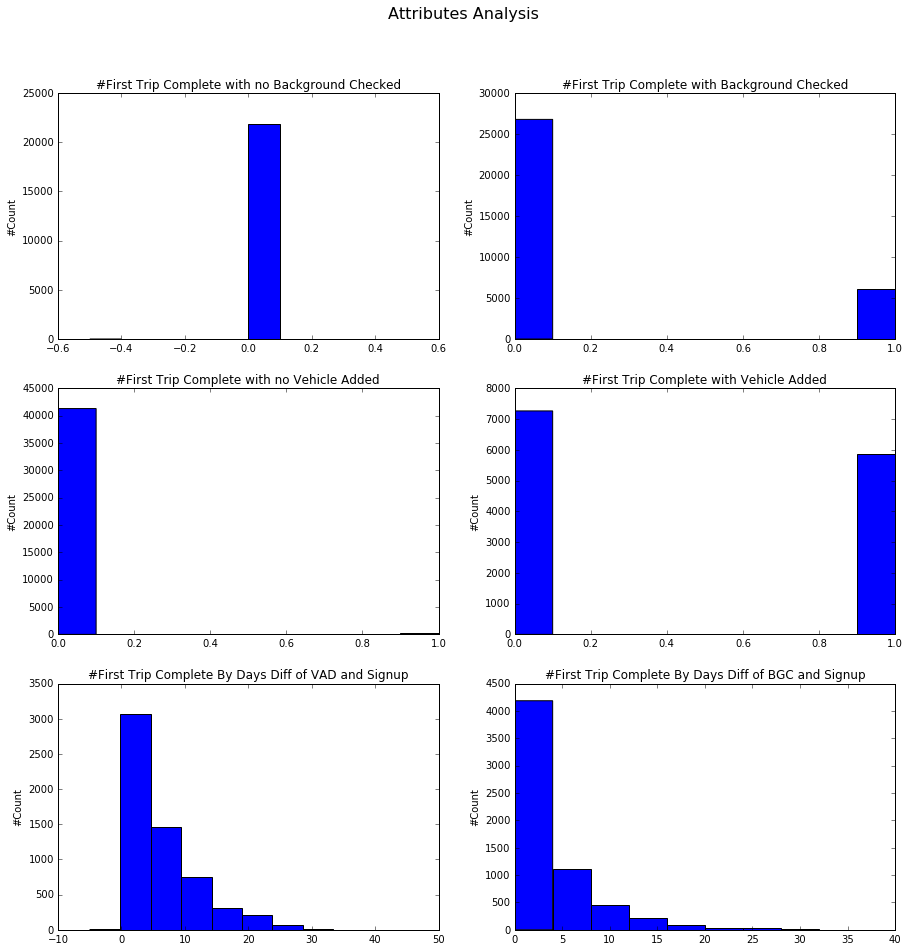

In [15]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(15, 15))
fig.suptitle("Attributes Analysis", fontsize=16)
ax1 = plt.subplot("321")
ax1.set_title("#First Trip Complete with no Background Checked")
ax1.hist(full_data['isstart'][full_data.null_bgc==1])
ax1.set_ylabel('#Count')

ax2 = plt.subplot("322")
ax2.set_title("#First Trip Complete with Background Checked")
ax2.hist(full_data['isstart'][full_data.null_bgc==0])
ax2.set_ylabel('#Count')

ax3 = plt.subplot("323")
ax3.set_title("#First Trip Complete with no Vehicle Added")
ax3.hist(full_data['isstart'][full_data.null_vad==1])
ax3.set_ylabel('#Count')

ax4 = plt.subplot("324")
ax4.set_title("#First Trip Complete with Vehicle Added")
ax4.hist(full_data['isstart'][full_data.null_vad==0])
ax4.set_ylabel('#Count')

ax5 = plt.subplot("325")
ax5.set_title("#First Trip Complete By Days Diff of VAD and Signup")
ax5.hist(full_data['vad_diff'][(full_data.null_vad==0) & (full_data.isstart==1)])
ax5.set_ylabel('#Count')

ax6 = plt.subplot("326")
ax6.set_title("#First Trip Complete By Days Diff of BGC and Signup")
ax6.hist(full_data['bgc_diff'][(full_data.null_bgc==0) & (full_data.isstart==1)])
ax6.set_ylabel('#Count')
plt.show()


## Stack Plot

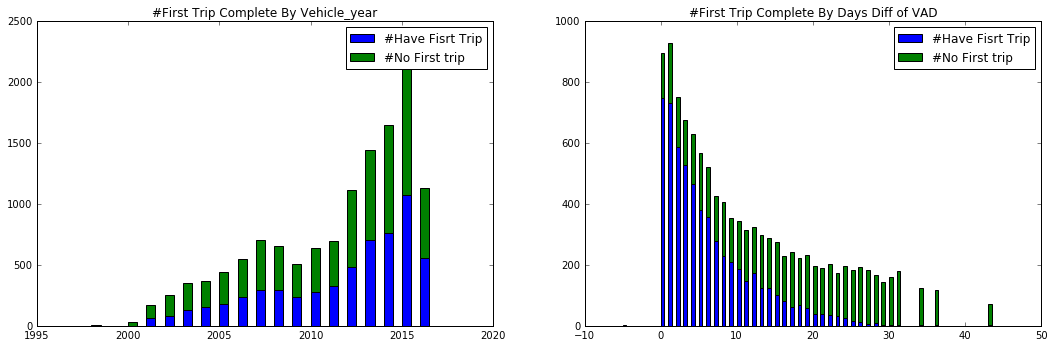

In [21]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(18, 12))
group1 = full_data[['vehicle_year','isstart']][(full_data.null_vad==0) & (full_data.isstart==1)].groupby('vehicle_year').count()
group1 = group1.reset_index(level=['vehicle_year'])
group2 = full_data[['vehicle_year','isstart']][(full_data.null_vad==0) & (full_data.isstart==0)].groupby('vehicle_year').count()
group2 = group2.reset_index(level=['vehicle_year'])
group3 = group1.merge(group2,how='outer',on='vehicle_year')
width = 0.5
ax1 = plt.subplot("221")
ax1.set_title("#First Trip Complete By Vehicle_year")
ax1.bar(group3['vehicle_year'],group3['isstart_x'], width, color='b')
ax1.bar(group3['vehicle_year'],group3['isstart_y'], width, color='g', bottom=group3['isstart_x'])
ax1.legend(('#Have Fisrt Trip', '#No First trip'))

group1 = full_data[['vad_diff','isstart']][(full_data.null_vad==0) & (full_data.isstart==1)].groupby('vad_diff').count()
group1 = group1.reset_index(level=['vehicle_year'])
group2 = full_data[['vad_diff','isstart']][(full_data.null_vad==0) & (full_data.isstart==0)].groupby('vad_diff').count()
group2 = group2.reset_index(level=['vad_diff'])
group3 = group1.merge(group2,how='outer',on='vad_diff')
width = 0.5
ax2 = plt.subplot("222")
ax2.set_title("#First Trip Complete By Days Diff of VAD")
ax2.bar(group3['vad_diff'],group3['isstart_x'], width, color='b')
ax2.bar(group3['vad_diff'],group3['isstart_y'], width, color='g', bottom=group3['isstart_x'])
ax2.legend(('#Have Fisrt Trip', '#No First trip'))

plt.show()

# Part3 Dimension Reduction and Feature Selection

## Feature Selection

### Random Forest Feature Importanace 

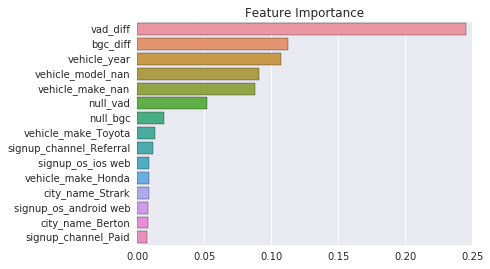

In [25]:

#feature importance

from sklearn.ensemble import RandomForestClassifier
import seaborn as sns
randomforest = RandomForestClassifier(random_state=24, n_estimators=100)
randomforest.fit(full_data_final, target)
# display the relative importance of each attribute
            
top_features = np.array(sorted(zip(map(lambda x: round(x, 4), randomforest.feature_importances_), full_data_final.columns),
                               reverse=True)[:15])

top_f_name = list(top_features[:,1])
full_data_reduced = full_data_final[top_f_name]
top_f_score = top_features[:,0]

#plot top n features
%matplotlib inline
plt.figure()
plt.title("Feature Importance")
importance = [np.float(x) for x in top_features[:,0]]
sns.barplot(y=full_data_reduced.columns, x=importance)

### PCA Dimension Reduction

#### Normalize Data

In [30]:
#normalized data
from sklearn.preprocessing import scale
full_data_scaled = scale(full_data_final)
print "finished normalization"

finished normalization


#### Calculate PCA Scores (Cross Validation VAR)

In [ ]:
#Plot and try to find best number of PCA/FA components
%matplotlib inline
import matplotlib.pyplot as plt
from scipy import linalg

from sklearn.decomposition import PCA
from sklearn.cross_validation import cross_val_score
from sklearn.grid_search import GridSearchCV

n_components = np.arange(0, len(full_data_final.columns)/10, 1)  # options for n_components

def compute_scores(X):
    pca = PCA()
    pca_scores= []
    for n in n_components:
        pca.n_components = n
        pca_scores.append(np.mean(cross_val_score(pca, X)))

    return pca_scores

pca_scores= compute_scores(full_data_scaled)

print "PCA cross validation score finished"

#### PCA Score Graphs Plot

In [ ]:
plt.figure('PCA')
plt.title("PCA components")
plt.plot(n_components, pca_scores)

#### Kaiser Methods and Scree Test

##### Kaiser Methods

In [50]:
from sklearn.decomposition import PCA
pca = PCA(n_components = 50).fit(full_data_scaled)
def pca_summary(pca, standardised_data, out=True):
    names = ["PC"+str(i) for i in range(1, len(pca.explained_variance_ratio_)+1)]
    a = list(np.std(pca.transform(standardised_data), axis=0))
    b = list(pca.explained_variance_ratio_)
    c = [np.sum(pca.explained_variance_ratio_[:i]) for i in range(1, len(pca.explained_variance_ratio_)+1)]
    columns = pd.MultiIndex.from_tuples([("sdev", "Standard deviation"), ("varprop", "Proportion of Variance"), ("cumprop", "Cumulative Proportion")])
    summary = pd.DataFrame(zip(a, b, c), index=names, columns=columns)
    if out:
        print("Importance of components:")
        display(summary.head())
    return summary

summary = pca_summary(pca, full_data_scaled)

print 'Kaiser Methods'

sdev_df = summary.sdev
print 'number of components to keep:',len(sdev_df[sdev_df['Standard deviation']>1])

Importance of components:


,sdev,varprop,cumprop
,Standard deviation,Proportion of Variance,Cumulative Proportion
PC1,2.337161,0.012615,0.012615
PC2,1.463245,0.004945,0.017560
PC3,1.447394,0.004838,0.022398
PC4,1.438492,0.004779,0.027177
PC5,1.431637,0.004733,0.031910


Kaiser Methods
number of components to keep: 50


##### Scree Test

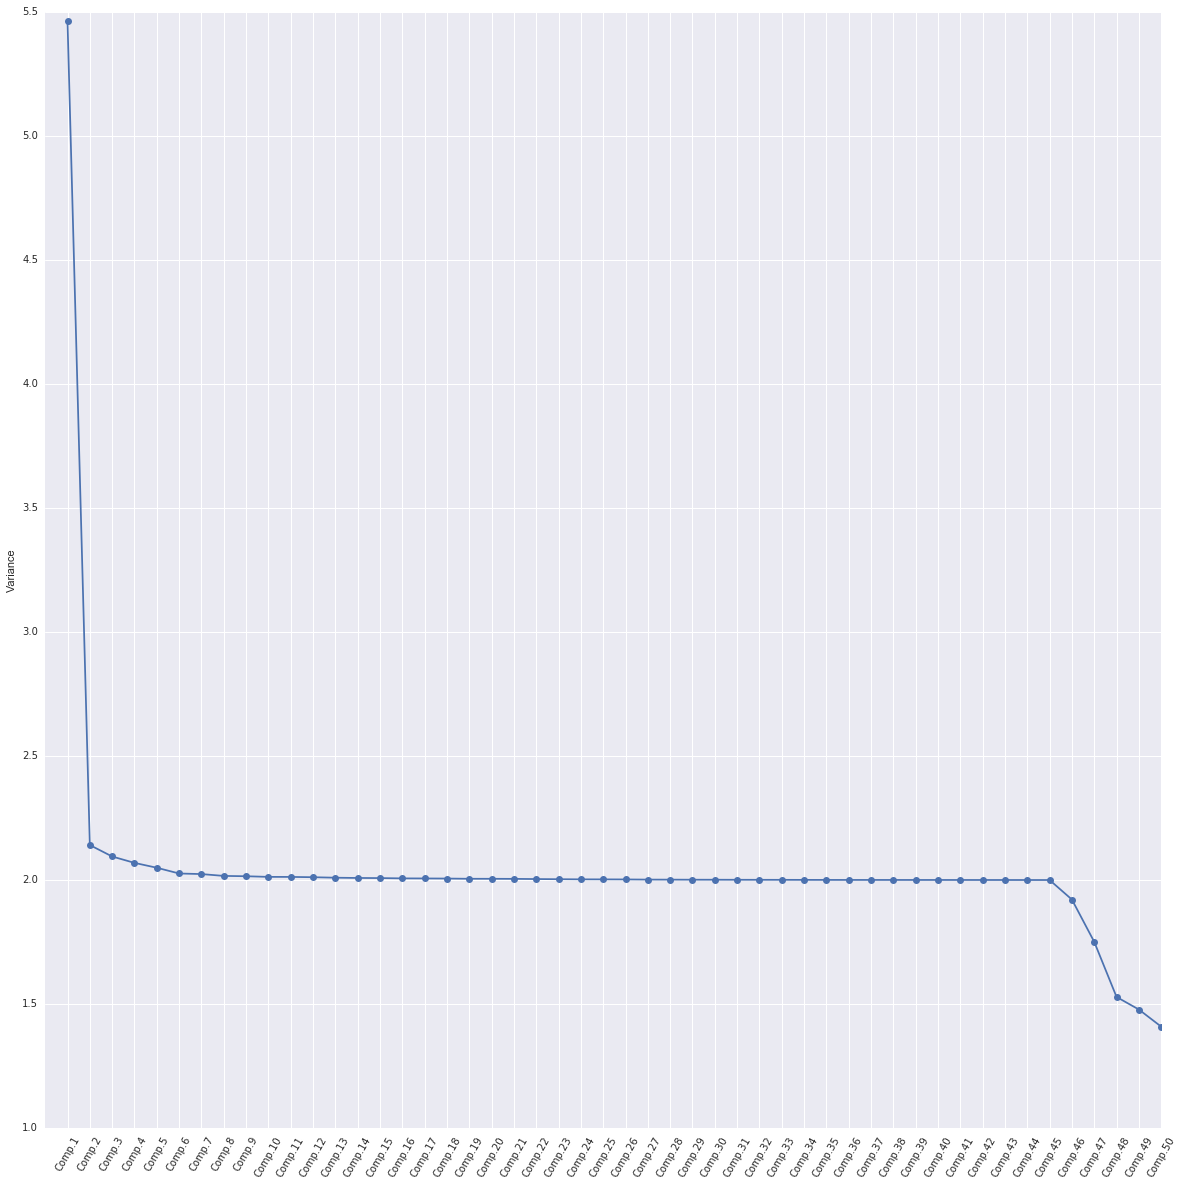

In [51]:
%matplotlib inline
pca = PCA(n_components = 50).fit(full_data_scaled)
import matplotlib.pyplot as plt
def screeplot(pca, standardised_values):
    y = np.std(pca.transform(standardised_values), axis=0)**2
    x = np.arange(len(y)) + 1
    plt.figure(figsize=(20, 20))
    plt.plot(x, y, "o-")
    plt.xticks(x, ["Comp."+str(i) for i in x], rotation=60)
    plt.ylabel("Variance")
    plt.show()

screeplot(pca, full_data_scaled)

#### Run PCA

In [58]:
#Try PCA do a dimensional reduction
from sklearn.decomposition import PCA
pca = PCA(n_components=15)
full_data_pca = pca.fit_transform(full_data_scaled)

#### Build a Polynomial dataset

In [ ]:
#Try polynomail
from sklearn import preprocessing
poly = preprocessing.PolynomialFeatures(2)
full_data_pca_poly = poly.fit_transform(full_data_pca)

# Part4 Model Selection with Cross Validation

## Score Seletion

### Classification using F1 Score

In [53]:
from sklearn.metrics import make_scorer, f1_score
score = make_scorer(f1_score, greater_is_better=True)

### None Classification use MSE

In [54]:
from sklearn.metrics import make_scorer, mean_squared_error
score = make_scorer(f1_score, greater_is_better=False)

## Pick Model and Parameters

### Random Forest

In [ ]:
#Random Forest
from sklearn import grid_search
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import make_scorer, f1_score, accuracy_score
randomforest = RandomForestClassifier(random_state=24, n_estimators=100)
tree_score = make_scorer(f1_score, greater_is_better=True)
parameters = {'max_depth': [x for x in range(8, 16)], 'min_samples_split': [x * 10 for x in range(5, 10)]}
clf_rf = grid_search.GridSearchCV(estimator=randomforest, param_grid=parameters, cv=10, scoring=tree_score)
clf_rf.fit(full_data_pca,target)
print "best parameter Random Forest", clf_rf.best_estimator_
print "best score  Random Forest", clf_rf.best_score_
 
print 'finish Random Forest'

### AdaBoost Decision Tree

In [ ]:

#AdaBoost Tree

target1 = np.array(target)

from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import grid_search
from sklearn.metrics import make_scorer, mean_squared_error, accuracy_score
from sklearn import cross_validation

# tree_score= make_scorer(output_restric ,greater_is_better=False)
tree_score = make_scorer(f1_score, greater_is_better=True)

parameters = {'learning_rate': [x * 0.1 for x in range(1, 11)]}
score_record = pd.DataFrame(columns=['Depth','Score'])
kf = cross_validation.KFold(len(full_data_final), n_folds=10)
for max_depth in range(1, 4):
    average_score = 0.0
    for train, test in kf:
        X_train, X_test, Y_train, Y_test = full_data_pca[train], full_data_pca[test], target1[
            train], target1[test]
        finalAdaB = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=max_depth, min_samples_split=50),
                                       n_estimators=100,
                                       learning_rate=0.1,
                                       random_state=42)
        finalAdaB.fit(X_train, Y_train)
        average_score += f1_score(Y_test, finalAdaB.predict(X_test))
    score_record = score_record.append(pd.DataFrame([[max_depth, average_score/10]], columns=['Depth', 'Score']))
        
best_score_ada = max(score_record['Score'])

print 'Best AdaBoost Parameter is', score_record[score_record.Score == best_score_ada]
print 'Best AdaBoost Score is', best_score_ada

print 'finish Adaboost Decision Tree'

### Logistic Regression

In [ ]:
# Logistic Regression
from sklearn import grid_search
from sklearn import linear_model
from sklearn.metrics import make_scorer, f1_score, accuracy_score

LogisticReg = linear_model.LogisticRegression(max_iter=100)
parameters = {'C': np.arange(0.01, 2, 0.01)}
lreg_score = make_scorer(f1_score, greater_is_better=True)

clf_lReg = grid_search.GridSearchCV(estimator=LogisticReg, param_grid=parameters, cv=10, scoring=lreg_score)
clf_lReg.fit(full_data_pca,target)
print "best parameter original", clf_lReg.best_estimator_
print "best score original", clf_lReg.best_score_

## Using Model with best score and run model on whole dataset

In [ ]:
#Use Reduced/full data to fit the best model
clf_RF_reduced = RandomForestClassifier(min_samples_split=80,max_depth=7,random_state=24, n_estimators=1000)
clf_RF_reduced.fit(full_data_pca,target)
print "Model F1 Score", f1_score(target,clf_RF_reduced.predict(full_data_pca))
print "Model Accuracy", accuracy_score(target,clf_RF_reduced.predict(full_data_pca))

## Finalize model result and do productionlization and predictions